In [578]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split, KFold, GroupKFold, BaseCrossValidator, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.base import ClassifierMixin
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

We start importing the data set to study the different columns relevance.

In [579]:
raw_data = pd.read_csv("dataset.csv")
raw_data.head()


,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,5-6 hours,Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,Less than 5 hours,Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,7-8 hours,Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,5-6 hours,Moderate,M.Tech,Yes,1.0,1.0,No,0


In [580]:
num_rows, num_columns = raw_data.shape
print(f"The dataset has {num_rows} rows and {num_columns} columns.")

The dataset has 27901 rows and 18 columns.


# Relevance of all variables: 

id: Unique identifier for each respondent; irrelevant for analysis (can be dropped).

Gender: Helps identify gender-based trends or disparities in depression levels.

Age: Relevant for analyzing how depression correlates with age.

City: Useful for identifying regional patterns in mental health.

Profession: Captures the impact of professional status (e.g., being a student) on depression.

Academic Pressure: Key to understanding the role of academic stress in mental health.

Work Pressure: Helps analyze how work-related stress impacts depression.

CGPA: Reflects academic performance, which may correlate with mental health.

Study Satisfaction: Indicates how satisfaction with studies influences depression.

Job Satisfaction: Relevant for understanding the impact of job fulfillment on mental well-being.

Sleep Duration: Critical for exploring the relationship between sleep habits and mental health.

Dietary Habits: Highlights how diet quality affects mental health.

Degree: Useful for analyzing mental health trends across different education levels.

Have you ever had suicidal thoughts?: Directly related to understanding extreme mental health risks.

Work/Study Hours: Reflects the impact of workload on mental health.

Financial Stress: Important for evaluating the role of financial factors in mental health.

Family History of Mental Illness: Crucial for understanding genetic or familial influences on depression.

Depression: The target variable for predictive analysis.

# DATA CLEANING

In [581]:
# Delete id column
raw_data.drop(columns=['id'], axis=1, inplace=True)

# Check missing values
missing_values = raw_data.isna().sum()
print(f"NA per column: \n{missing_values}")
print(f"total NA: {missing_values.sum()}")


NA per column: 
Gender                                   0
Age                                      0
City                                     0
Profession                               0
Academic Pressure                        0
Work Pressure                            0
CGPA                                     0
Study Satisfaction                       0
Job Satisfaction                         0
Sleep Duration                           0
Dietary Habits                           0
Degree                                   0
Have you ever had suicidal thoughts ?    0
Work/Study Hours                         0
Financial Stress                         3
Family History of Mental Illness         0
Depression                               0
dtype: int64
total NA: 3


We see that the missing values exclusively are in the financial Stress column. We replace these 3 missing values by median of the whole datasets Financial Stress values.

In [582]:
financial_stress_median = raw_data['Financial Stress'].median()
raw_data['Financial Stress'].fillna(financial_stress_median, inplace=True)

/tmp/ipykernel_3589376/2780200284.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  raw_data['Financial Stress'].fillna(financial_stress_median, inplace=True)


Since it's a survey, we ensure that all the "yes" and "no" are standardized, are typed in lowercase in our case.

In [583]:
# Sleep duration analysis
# Check they are all students
unique_sleep_hours = raw_data['Sleep Duration'].unique()
print("The usual sleep durations are ", unique_sleep_hours)

# Count the occurrences of each degree category
sleep_hours_counts = raw_data['Sleep Duration'].value_counts()
print("\nCount of data for sleep duration:\n", sleep_hours_counts)

The usual sleep durations are  ['5-6 hours' 'Less than 5 hours' '7-8 hours' 'More than 8 hours' 'Others']

Count of data for sleep duration:
 Sleep Duration
Less than 5 hours    8310
7-8 hours            7346
5-6 hours            6183
More than 8 hours    6044
Others                 18
Name: count, dtype: int64


In [584]:
# Check they are all students
unique_professions = raw_data['Profession'].unique()
print("The professions are ", unique_professions)

student_count = raw_data['Profession'].str.count('Student').sum()
print(f"The students are {student_count}.")

num_rows, num_columns = raw_data.shape
print(f"The dataset has {num_rows} rows and {num_columns} columns.")

print(f'The non students are {num_rows-student_count}')

The professions are  ['Student' 'Civil Engineer' 'Architect' 'UX/UI Designer'
 'Digital Marketer' 'Content Writer' 'Educational Consultant' 'Teacher'
 'Manager' 'Chef' 'Doctor' 'Lawyer' 'Entrepreneur' 'Pharmacist']
The students are 27870.
The dataset has 27901 rows and 17 columns.
The non students are 31


COMMENT: Since the goal is detecting the depression status among students, we need to remove from the dataset the rows containing data of non-students. 

In [585]:
# Keep only students' data
df_clean = raw_data[raw_data['Profession'] == 'Student'] 

# Check they have been corretly deleted
num_rows, num_columns = df_clean.shape
print(f"The dataset has {num_rows} rows and {num_columns} columns.")

The dataset has 27870 rows and 17 columns.


In [586]:
# Analyse the Dietary Habits
unique_diet_habits = df_clean['Dietary Habits'].unique()
print("The Dietary Habits are ", unique_diet_habits)

# Count the occurrences of each degree category
diet_habits_counts = df_clean['Dietary Habits'].value_counts()
print("\nCount of data for dietary habit is:\n", diet_habits_counts)

The Dietary Habits are  ['Healthy' 'Moderate' 'Unhealthy' 'Others']

Count of data for dietary habit is:
 Dietary Habits
Unhealthy    10309
Moderate      9910
Healthy       7639
Others          12
Name: count, dtype: int64


COMMENT: The 'Others' category has only 12 instances, making it significantly underrepresented compared to the other dietary habits. Keeping such a small category could introduce noise, reduce model stability, and hinder generalization. Removing it ensures a more balanced and reliable classification model.

In [587]:
# Remove the data of students that have classified their dietary habits as "others"
df_clean = df_clean[df_clean['Dietary Habits'] != 'Others']
print(df_clean['Dietary Habits'].value_counts())

Dietary Habits
Unhealthy    10309
Moderate      9910
Healthy       7639
Name: count, dtype: int64


In [588]:
# Check the various degree of students
unique_degrees = df_clean['Degree'].unique()
print("The Degrees are ", unique_degrees)

The Degrees are  ['B.Pharm' 'BSc' 'BA' 'BCA' 'M.Tech' 'PhD' 'Class 12' 'B.Ed' 'LLB' 'BE'
 'M.Ed' 'MSc' 'BHM' 'M.Pharm' 'MCA' 'MA' 'B.Com' 'MD' 'MBA' 'MBBS' 'M.Com'
 'B.Arch' 'LLM' 'B.Tech' 'BBA' 'ME' 'MHM' 'Others']


In [589]:
# Encode the information and split them into two columns: 
# one specifying the level od education and one the faculty of study. 

# Define the degree mapping (Education level and Faculty)
degree_mapping = {
    'B.Pharm': ('Bachelor', 'Pharmacy'),
    'BSc': ('Bachelor', 'Sciences'),
    'BA': ('Bachelor', 'Arts'),
    'BCA': ('Bachelor', 'Computer Science'),
    'M.Tech': ('Master', 'Technology'),
    'PhD': ('Master', 'Philosophy'),
    'Class 12': ('High School', 'No Faculty'),  # Class 12 is high school
    'B.Ed': ('Bachelor', 'Education'),
    'LLB': ('Bachelor', 'Law'),
    'BE': ('Bachelor', 'Engineering'),
    'M.Ed': ('Master', 'Education'),
    'MSc': ('Master', 'Sciences'),
    'BHM': ('Bachelor', 'Turism'),
    'M.Pharm': ('Master', 'Pharmacy'),
    'MCA': ('Master', 'Computer Science'),
    'MA': ('Master', 'Arts'),
    'B.Com': ('Bachelor', 'Economics'),
    'MD': ('Master', 'Medicine'),
    'MBA': ('Master', 'Economics'),
    'MBBS': ('Bachelor', 'Medicine'),
    'M.Com': ('Master', 'Economics'),
    'B.Arch': ('Bachelor', 'Architecture'),
    'LLM': ('Master', 'Law'),
    'B.Tech': ('Bachelor', 'Technology'),
    'BBA': ('Bachelor', 'Economics'),
    'ME': ('Master', 'Engineering'),
    'MHM': ('Master', 'Turism'),
    'Others': ('Others', 'Others')
}

# NEW VARIABLES CREATION: 1. EDUCATION LEVEL, 2. FACULTY
# Apply the degree mapping function to the 'Degree' column and create new 'Level' and 'Faculty' columns
df_clean[['Education Level', 'Faculty']] = df_clean['Degree'].apply(lambda x: pd.Series(degree_mapping.get(x, ('None', 'None'))))

# Display the DataFrame with the new columns
print(df_clean)
df_clean.shape

       Gender   Age           City Profession  Academic Pressure  \
0        Male  33.0  Visakhapatnam    Student                5.0   
1      Female  24.0      Bangalore    Student                2.0   
2        Male  31.0       Srinagar    Student                3.0   
3      Female  28.0       Varanasi    Student                3.0   
4      Female  25.0         Jaipur    Student                4.0   
...       ...   ...            ...        ...                ...   
27896  Female  27.0          Surat    Student                5.0   
27897    Male  27.0       Ludhiana    Student                2.0   
27898    Male  31.0      Faridabad    Student                3.0   
27899  Female  18.0       Ludhiana    Student                5.0   
27900    Male  27.0          Patna    Student                4.0   

       Work Pressure  CGPA  Study Satisfaction  Job Satisfaction  \
0                0.0  8.97                 2.0               0.0   
1                0.0  5.90                 5.0 

(27858, 19)

In [590]:
# Print unique degrees in the 'Education level' column
unique_ed_level = df_clean['Education Level'].unique()
print("The education levels are:", unique_ed_level)

# Count the occurrences of each degree category
ed_level_counts = df_clean['Education Level'].value_counts()
print("\nCount of data for each education level:\n", ed_level_counts)

The education levels are: ['Bachelor' 'Master' 'High School' 'Others']

Count of data for each education level:
 Education Level
Bachelor       13312
Master          8432
High School     6079
Others            35
Name: count, dtype: int64


COMMENT: The 'Others' category has only 35 instances (very low with respect to the remaining categories), making it significantly underrepresented compared to the other educational levels. Keeping such a small category could introduce noise, reduce model stability, and hinder generalization. Removing it ensures a more balanced and reliable classification model.

In [591]:
# Remove the data of students that have classified their educational level as "others"
df_clean = df_clean[df_clean['Education Level'] != 'Others']
print(df_clean['Education Level'].value_counts())

Education Level
Bachelor       13312
Master          8432
High School     6079
Name: count, dtype: int64


In [592]:
# Print unique degrees in the 'Faculty' column
unique_ed_level = df_clean['Faculty'].unique()
print("The faculties are:", unique_ed_level)

# Count the occurrences of each degree category
ed_level_counts = df_clean['Faculty'].value_counts()
print("\nCount of data for each faculty:\n", ed_level_counts)

The faculties are: ['Pharmacy' 'Sciences' 'Arts' 'Computer Science' 'Technology' 'Philosophy'
 'No Faculty' 'Education' 'Law' 'Engineering' 'Turism' 'Economics'
 'Medicine' 'Architecture']

Count of data for each faculty:
 Faculty
No Faculty          6079
Economics           3495
Education           2683
Computer Science    2471
Technology          2173
Sciences            2070
Architecture        1477
Pharmacy            1388
Medicine            1264
Law                 1151
Arts                1141
Turism              1113
Engineering          797
Philosophy           521
Name: count, dtype: int64


In [593]:
# We remove the variable Degree after having reorganized its content 
# in the two new variables Education level and Faculty
df_clean.drop('Degree', axis=1, inplace=True)
print(df_clean)
df_clean.shape

       Gender   Age           City Profession  Academic Pressure  \
0        Male  33.0  Visakhapatnam    Student                5.0   
1      Female  24.0      Bangalore    Student                2.0   
2        Male  31.0       Srinagar    Student                3.0   
3      Female  28.0       Varanasi    Student                3.0   
4      Female  25.0         Jaipur    Student                4.0   
...       ...   ...            ...        ...                ...   
27896  Female  27.0          Surat    Student                5.0   
27897    Male  27.0       Ludhiana    Student                2.0   
27898    Male  31.0      Faridabad    Student                3.0   
27899  Female  18.0       Ludhiana    Student                5.0   
27900    Male  27.0          Patna    Student                4.0   

       Work Pressure  CGPA  Study Satisfaction  Job Satisfaction  \
0                0.0  8.97                 2.0               0.0   
1                0.0  5.90                 5.0 

(27823, 18)

In [594]:
# Check cities
def check_count(var:str):
    total = df_clean.groupby(var).count()['Depression']
    print(total[total < max(total)/100])
    print(f'\nNumber of entries with a low number of values for {var}: {total[total < max(total)/100].sum()}\n')
    print('\n\n============================================================\n\n')
    unreal_cities = list(total[total < max(total)/100].keys())
    return unreal_cities

In [595]:
# City analysis
# Check whether the city are correct
unreal_cities = check_count('City')

# Age analysis to prepare plot 
under_rep_age = check_count('Age')
# under_rep_job_statisfaction = check_count('Job Satisfaction')
# under_rep_job = check_count('Profession')
# under_rep_degree = check_count('Degree')

City
3.0                   1
Bhavna                2
City                  2
Gaurav                1
Harsh                 1
Harsha                2
Khaziabad             1
Kibara                1
Less Delhi            1
Less than 5 Kalyan    1
M.Com                 1
M.Tech                1
ME                    1
Mihir                 1
Mira                  1
Nalini                1
Nalyan                1
Nandini               1
Rashi                 1
Reyansh               1
Saanvi                2
Vaanya                1
Name: Depression, dtype: int64

Number of entries with a low number of values for City: 26





Age
35.0    10
36.0     7
37.0     2
38.0     8
39.0     3
41.0     1
42.0     4
43.0     2
44.0     1
46.0     2
48.0     3
49.0     1
51.0     1
54.0     1
56.0     1
58.0     1
59.0     1
Name: Depression, dtype: int64

Number of entries with a low number of values for Age: 49







COMMENT: Most of the cities listed are in India. The others are invalid, likely due to typing mistakes or general errors. If the dataset comes from a survey, some respondents may have mistakenly entered their names instead of their city of residence or simply wrongly answered. Let's remove the invalid cities.   

In [596]:
df_clean = df_clean[~df_clean['City'].isin(unreal_cities)]

COMMENT: After those modifications, the city column contains only valid cities (on df_clean). Moreover, we notice that all those cities are in India. 

In [597]:
# Analyse the work pressure
# Check they are all students
unique_work_pressure = df_clean['Work Pressure'].unique()
print("The felt work pressure can be ", unique_work_pressure)

# Count the occurrences of each degree category
work_pressure_counts = df_clean['Work Pressure'].value_counts()
print("\nCount of data for work pressure\n", work_pressure_counts)

The felt work pressure can be  [0. 5. 2.]

Count of data for work pressure
 Work Pressure
0.0    27794
5.0        2
2.0        1
Name: count, dtype: int64


COMMENT: As they are all students, they usually not work, so they can't feel this kind of pressure unless they are undertaking some working activities during their studies. 
Since the variable is mostly characterized by zeros (more than 99%), we can drop the variable from the dataset. 

In [598]:
df_clean.drop('Work Pressure', axis=1, inplace=True)

In [599]:
# Analyse the Job Satisfaction
unique_job_satisf = df_clean['Job Satisfaction'].unique()
print("The felt job satisfaction can be ", unique_job_satisf)

# Count the occurrences of each degree category
job_satisf_counts = df_clean['Job Satisfaction'].value_counts()
print("\nCount of data for job satisfaction\n", job_satisf_counts)

The felt job satisfaction can be  [0. 3. 4. 2. 1.]

Count of data for job satisfaction
 Job Satisfaction
0.0    27789
2.0        3
4.0        2
1.0        2
3.0        1
Name: count, dtype: int64


In [600]:
df_clean.drop('Job Satisfaction', axis=1, inplace=True)

COMMENT: As before, being all students, they can't be satisfacted for their job since they are not working. Since the variable is mostly characterized by zeros (more than 99%), we can drop the variable from the dataset. 

In [601]:
# Analyse the Academic Pressure
unique_acad_press = df_clean['Academic Pressure'].unique()
print("The felt academic pressure can be ", unique_acad_press)

# Count the occurrences of each degree category
acad_press_counts = df_clean['Academic Pressure'].value_counts()
print("\nCount of data for academic pressure\n", acad_press_counts)

The felt academic pressure can be  [5. 2. 3. 4. 1. 0.]

Count of data for academic pressure
 Academic Pressure
3.0    7426
5.0    6273
4.0    5141
1.0    4787
2.0    4161
0.0       9
Name: count, dtype: int64


COMMENT: The 'Others' category has only 18 instances (very low with respect to the remaining categories), making it significantly underrepresented compared to the other levels of academic pressure. Keeping such a small category could introduce noise, reduce model stability, and hinder generalization. Removing it ensures a more balanced and reliable classification model.

In [602]:
# Remove the data of students that have classified their dietary habits as "others"
df_clean = df_clean[df_clean['Academic Pressure'] != 0]
print(df_clean['Academic Pressure'].value_counts())

Academic Pressure
3.0    7426
5.0    6273
4.0    5141
1.0    4787
2.0    4161
Name: count, dtype: int64


In [603]:
# Analyse the Study Satisfaction
# Check they are all students
unique_study_satisf = df_clean['Study Satisfaction'].unique()
print("The felt study satisfaction can be ", unique_study_satisf)

# Count the occurrences of each degree category
study_satisf_counts = df_clean['Study Satisfaction'].value_counts()
print("\nCount of data for study satisfaction\n", study_satisf_counts)

The felt study satisfaction can be  [2. 5. 3. 4. 1. 0.]

Count of data for study satisfaction
 Study Satisfaction
4.0    6337
2.0    5818
3.0    5796
1.0    5429
5.0    4405
0.0       3
Name: count, dtype: int64


COMMENT: The 'Others' category has only 18 instances (very low with respect to the remaining categories), making it significantly underrepresented compared to the other levels of study satisfaction. Keeping such a small category could introduce noise, reduce model stability, and hinder generalization. Removing it ensures a more balanced and reliable classification model.

In [604]:
# Remove the data of students that have classified their dietary habits as "others"
df_clean = df_clean[df_clean['Study Satisfaction'] != 0]
print(df_clean['Study Satisfaction'].value_counts())

Study Satisfaction
4.0    6337
2.0    5818
3.0    5796
1.0    5429
5.0    4405
Name: count, dtype: int64


In [605]:
# For simplicity, we rename the dataset variables
df_clean = df_clean.rename(columns={"Have you ever had suicidal thoughts ?": "Suicidal Thoughts",
                              "Family History of Mental Illness": "Mental History", 
                             "Work/Study Hours": "Study Hours"})  #since we have only students
df_clean.columns
df_clean.shape

(27785, 16)

In [606]:
# Save to csv
df_clean.to_csv('Student_depression_cleaned.csv', index=False)

## DESCRIPTIVE STATISTICS

#### Categorical variables' analysis

In [607]:
sd_df = pd.read_csv('Student_depression_cleaned.csv')
sd_df.columns

Index(['Gender', 'Age', 'City', 'Profession', 'Academic Pressure', 'CGPA',
       'Study Satisfaction', 'Sleep Duration', 'Dietary Habits',
       'Suicidal Thoughts', 'Study Hours', 'Financial Stress',
       'Mental History', 'Depression', 'Education Level', 'Faculty'],
      dtype='object')

Balance of the response variable (Depression):


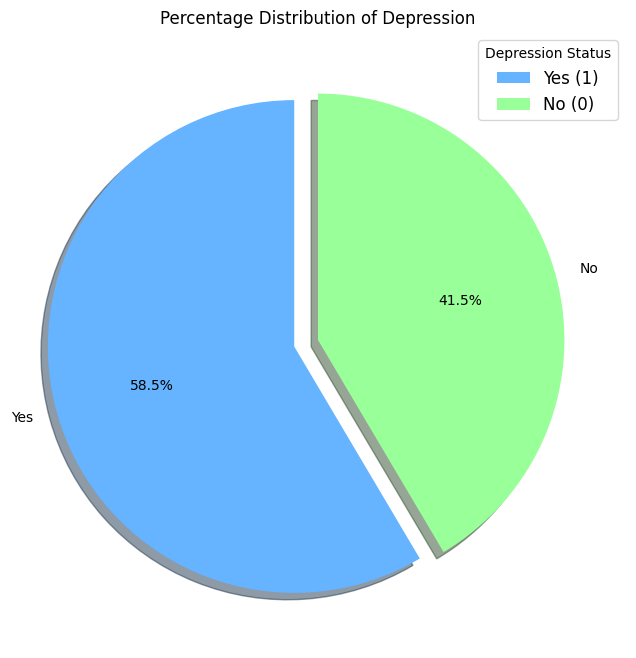

In [608]:
#### Balance Check
# Check the balance of the response variable (Depression)
print("Balance of the response variable (Depression):")
depression_counts = sd_df["Depression"].value_counts()
depression_percentages = depression_counts / depression_counts.sum() * 100

plt.figure(figsize=(8, 8))
plt.pie(
    depression_percentages, 
    labels=['Yes', 'No'],  # Custom labels for the classes (0 = No, 1 = Yes)
    autopct='%1.1f%%',  # Show percentages with 1 decimal point
    colors=['#66b3ff', '#99ff99'],  # Optional: customize colors
    startangle=90,  # Start angle for better orientation
    explode=(0.1, 0),  # Optional: explode the first slice slightly
    shadow=True  # Optional: add shadow for better visualization
)

# Add a legend
plt.legend(
    labels=['Yes (1)', 'No (0)'],  # Legend showing the class labels
    title="Depression Status",  # Title for the legend
    loc="best",  # Location of the legend
    fontsize=12  # Font size for the legend
)

# Add title
plt.title("Percentage Distribution of Depression")

# Show the pie chart
plt.show()

COMMENT: When working with imbalanced datasets, machine learning models may be biased towards the majority class, leading to poor performance in predicting the minority class. This is especially problematic in classification tasks where accurately predicting both classes is essential. Techniques like oversampling, undersampling, or SMOTE can help balance the dataset by increasing the minority class's representation. Balancing is necessary for models to learn both classes effectively and to improve metrics like precision, recall, and F1-score, which are crucial for accurate predictions in imbalanced settings. 

In [609]:
#### CHOOSE THE BALANCING TECHNIQUE
# Calculate the difference between the two categories
difference = depression_counts.get(1, 0) - depression_counts.get(0, 0)
print("Difference between the two classes (Depression=1 and Depression=0):", difference)

Difference between the two classes (Depression=1 and Depression=0): 4729


COMMENT: There is a difference of 4743 between the two classes, meaning that class 1 (Depression = Yes) is significantly overrepresented compared to class 0 (Depression = No). It suggests that the dataset is imbalanced in favor of class 1.

**Firstly, we apply the undersampling technique.** Its drawback is the probable loss of valuable data from the majority class, which might reduce the model's ability to generalize.

In [610]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

#### UNDERSAMPLING for the majority class 1, meaning suffering from depression
# Separate features (X) and target variable (y)
X = sd_df.drop(columns=["Depression"])  # All columns except 'Depression' 
y = sd_df["Depression"]  # Target variable

# Get the number of instances in the majority class (class 0)
majority_class_count = len(y[y == 0])

# Apply undersampling to balance the classes by setting class 1 to the same size as class 0
undersampler = RandomUnderSampler(sampling_strategy={1: majority_class_count}, random_state=42)

# Resample the dataset
X_resampled, y_resampled = undersampler.fit_resample(X, y)

# Check the new class distribution
print("Class distribution after undersampling:", Counter(y_resampled))

Class distribution after undersampling: Counter({0: 11528, 1: 11528})


In [611]:
df_resampled = pd.DataFrame(X_resampled, columns=X.columns)  
df_resampled["Depression"] = y_resampled 
df_resampled.shape

(23056, 16)

In [612]:
# For simplicity, we rename the dataset variables
df_resampled = df_resampled.rename(columns={"Have you ever had suicidal thoughts ?": "Suicidal Thoughts",
                              "Family History of Mental Illness": "Mental History", 
                             "Work/Study Hours": "Study Hours"})  #since we have only students


In [613]:
print(df_resampled)

       Gender   Age       City Profession  Academic Pressure  CGPA  \
1      Female  24.0  Bangalore    Student                2.0  5.90   
2        Male  31.0   Srinagar    Student                3.0  7.03   
4      Female  25.0     Jaipur    Student                4.0  8.13   
5        Male  29.0       Pune    Student                2.0  5.70   
6        Male  30.0      Thane    Student                3.0  9.54   
...       ...   ...        ...        ...                ...   ...   
4189   Female  33.0     Kalyan    Student                4.0  9.98   
24641  Female  25.0       Agra    Student                5.0  7.22   
14175    Male  24.0     Bhopal    Student                3.0  9.11   
23644    Male  18.0     Kalyan    Student                5.0  7.94   
10248    Male  23.0    Kolkata    Student                5.0  7.15   

       Study Satisfaction     Sleep Duration Dietary Habits Suicidal Thoughts  \
1                     5.0          5-6 hours       Moderate                No 

In [614]:
# Frequency of category for every categorical variable
# Assuming you're using df_resampled for the analysis, update this to your dataset variable name if needed
categorical_columns = ['Gender', 'City', 'Profession', 'Academic Pressure', 'Study Satisfaction',
                       'Sleep Duration', 'Dietary Habits', 'Suicidal Thoughts', 'Study Hours', 
                       'Financial Stress', 'Mental History', 'Education Level', 'Faculty']

# Loop through each categorical variable and calculate the frequency of categories
for column in categorical_columns:
    print(f"Frequency distribution for {column}:")
    print(df_resampled[column].value_counts())  # Use df_resampled or the dataset you want to analyze
    print("-" * 50)  # Separator for better readability

Frequency distribution for Gender:
Gender
Male      12859
Female    10197
Name: count, dtype: int64
--------------------------------------------------
Frequency distribution for City:
City
Kalyan           1294
Srinagar         1142
Hyderabad        1065
Vasai-Virar      1062
Lucknow           978
Thane             941
Agra              906
Ludhiana          903
Surat             892
Jaipur            879
Kolkata           865
Pune              819
Visakhapatnam     818
Patna             815
Ahmedabad         794
Bhopal            756
Chennai           732
Meerut            672
Rajkot            657
Delhi             638
Bangalore         634
Ghaziabad         627
Varanasi          582
Mumbai            579
Vadodara          560
Nagpur            544
Indore            540
Kanpur            517
Nashik            459
Faridabad         386
Name: count, dtype: int64
--------------------------------------------------
Frequency distribution for Profession:
Profession
Student    23056
Name: c

In [615]:
def percent_depression(var:str, data:pd.DataFrame):
    """
    Function to calculate the percentage of depression based on a specified variable in a DataFrame.

    Args:
        var (str): The name of the column to analyze in the DataFrame.
        data (pd.DataFrame): The DataFrame containing the data to analyze.

    Returns:
        float: The percentage of depression in the specified column.
    """
    total = data.groupby(var).count()['Depression']
    counts = data[data['Depression'] == 1].groupby(var)['Depression'].count()
    percentage = (counts / total) * 100

    plt.figure(figsize=(12, 6))
    percentage.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f"Depression percentage per {var}", fontsize=16)
    plt.xlabel(f"{var}", fontsize=14)
    plt.ylabel("Count of Depression", fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()


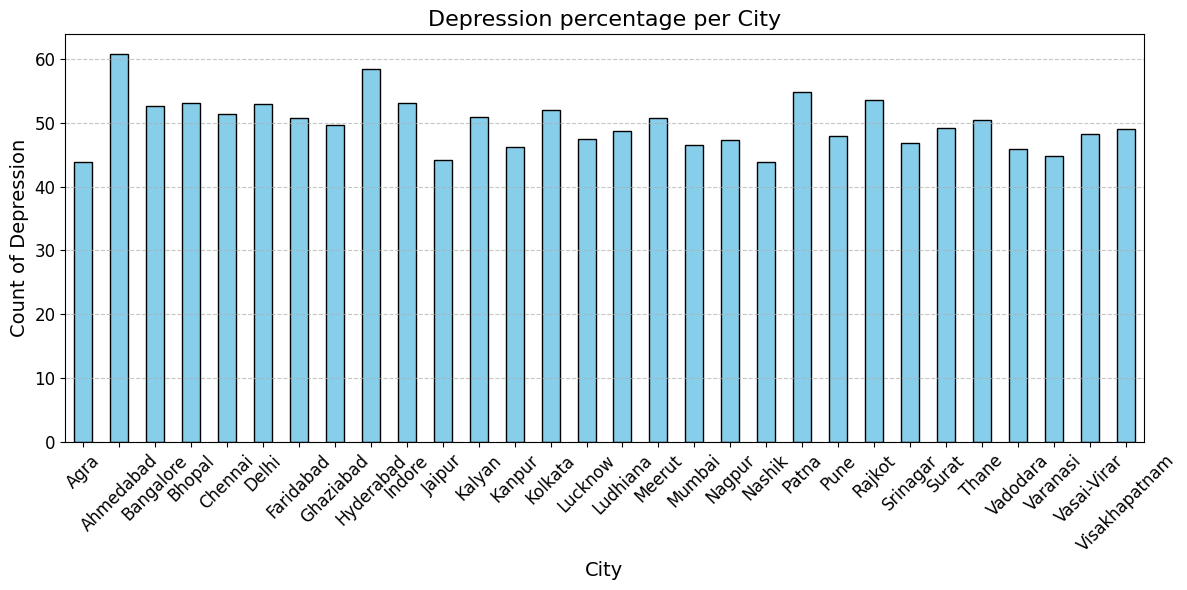

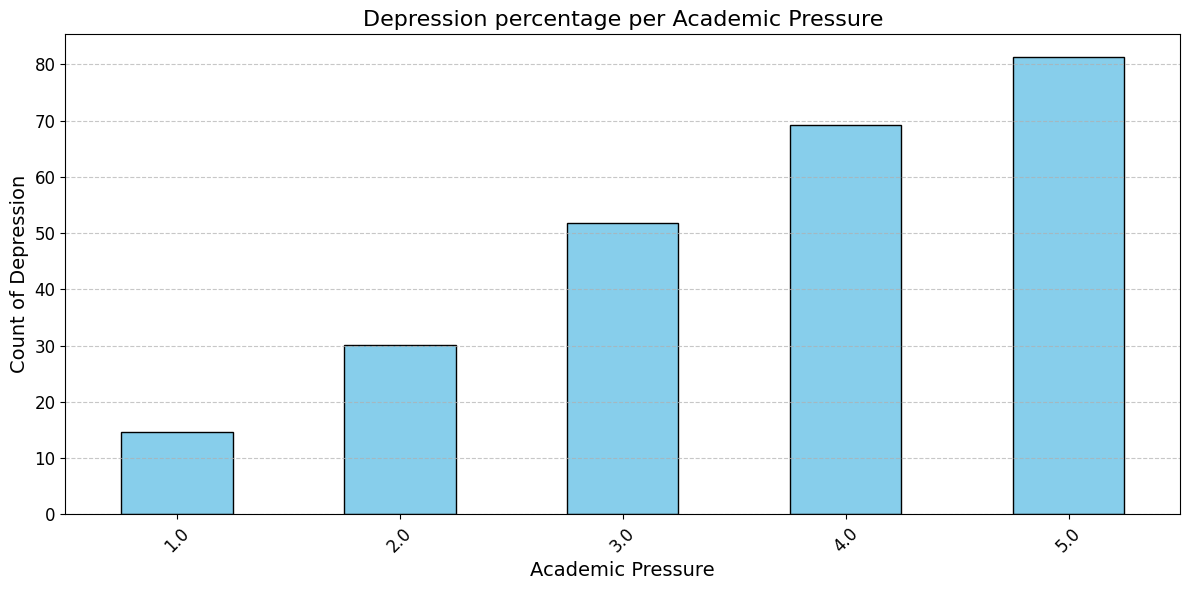

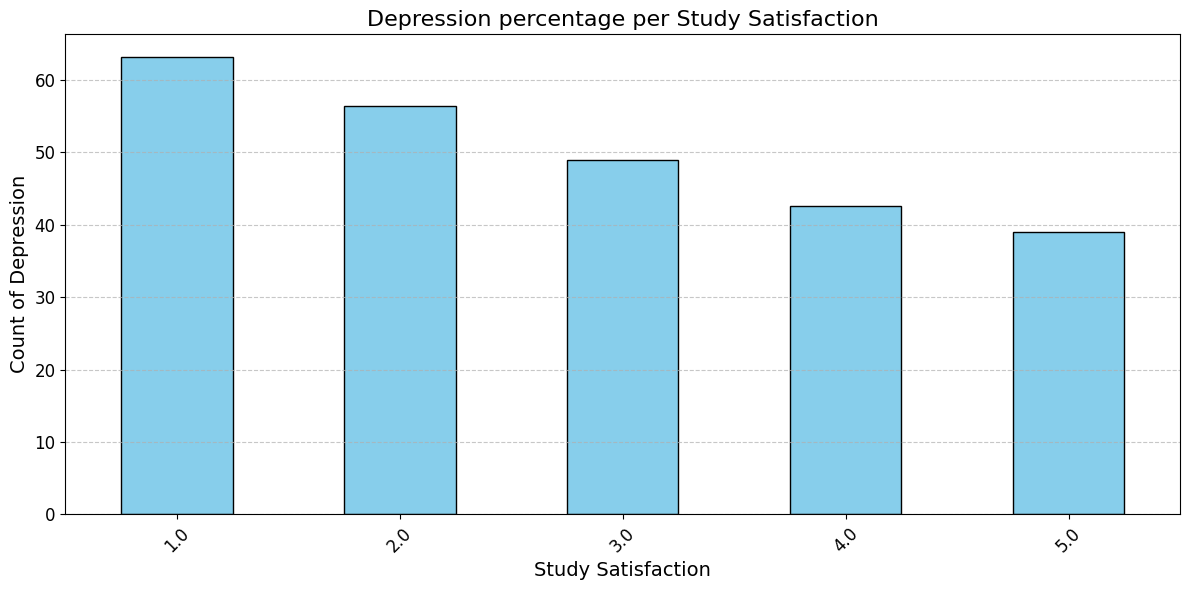

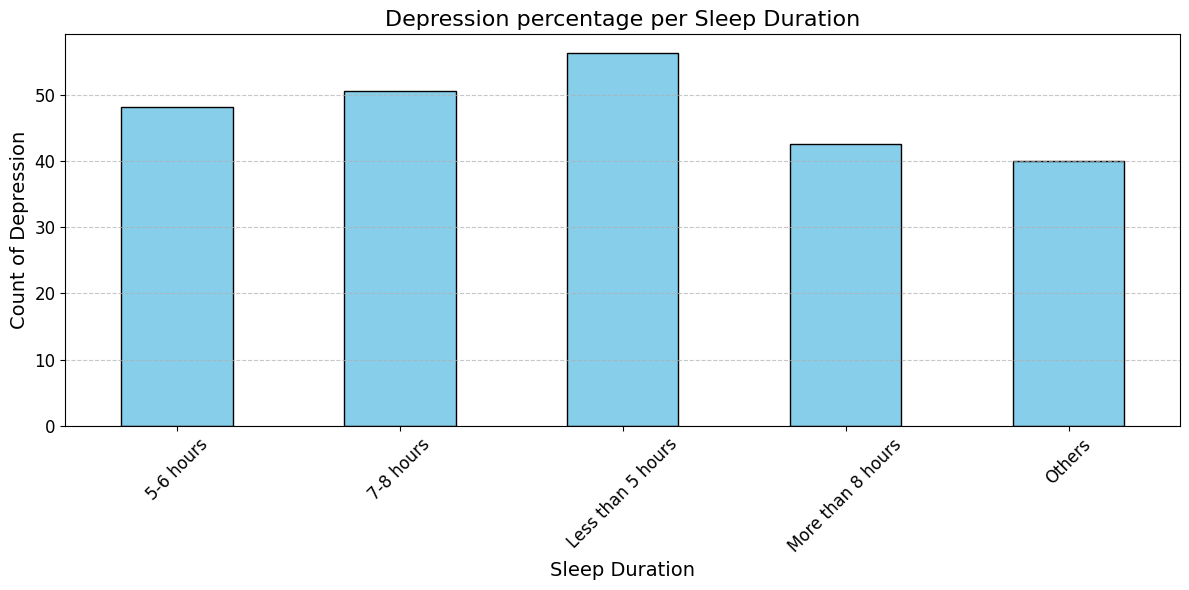

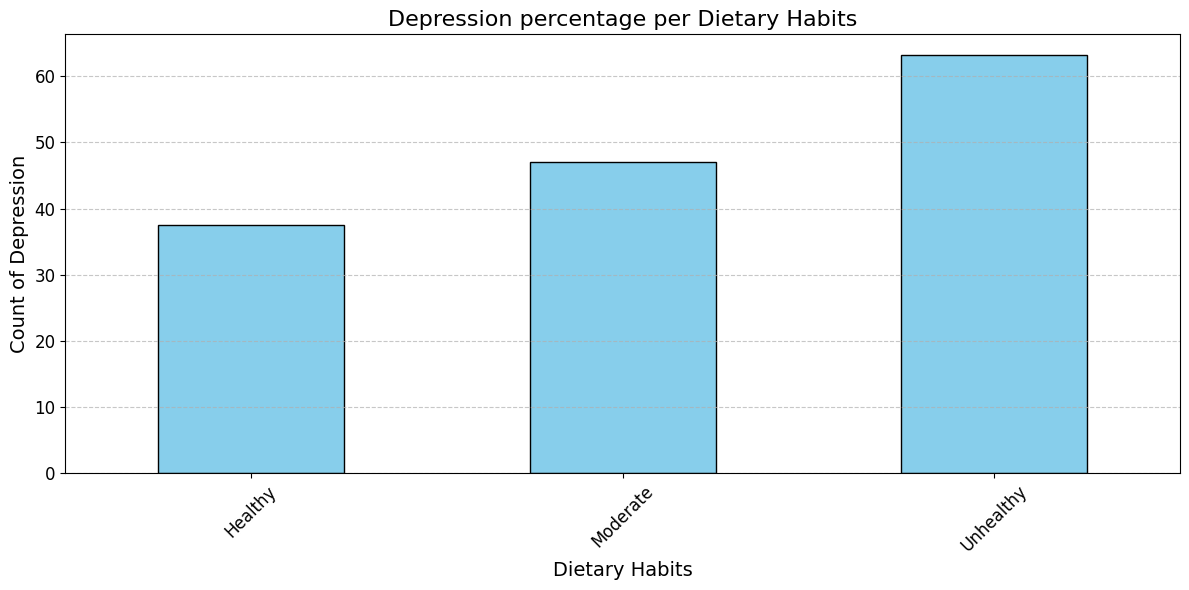

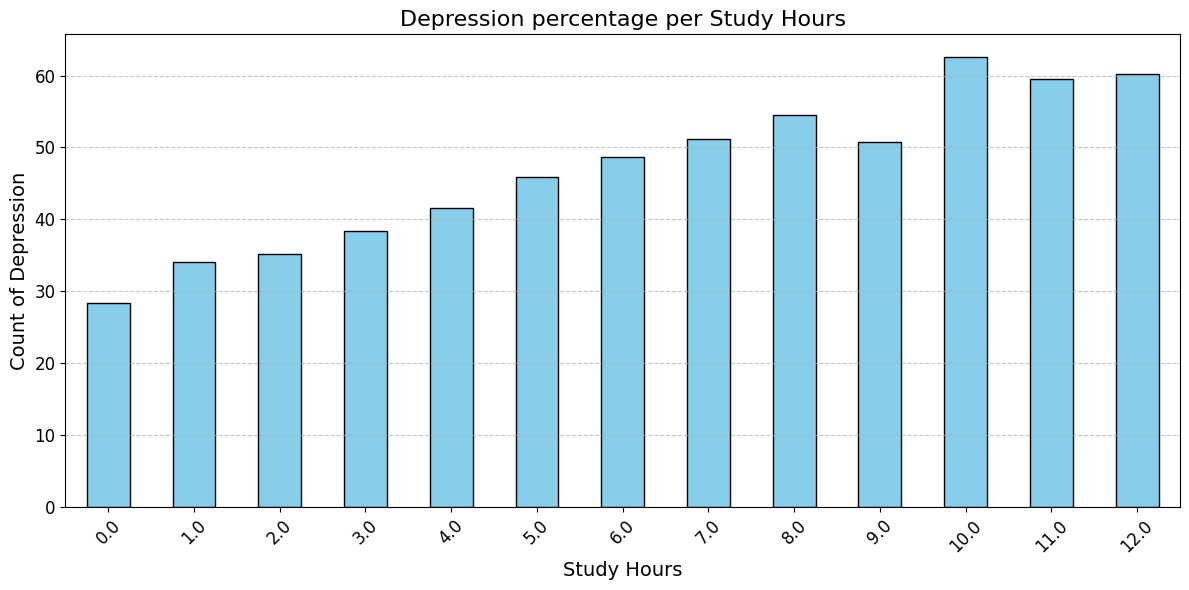

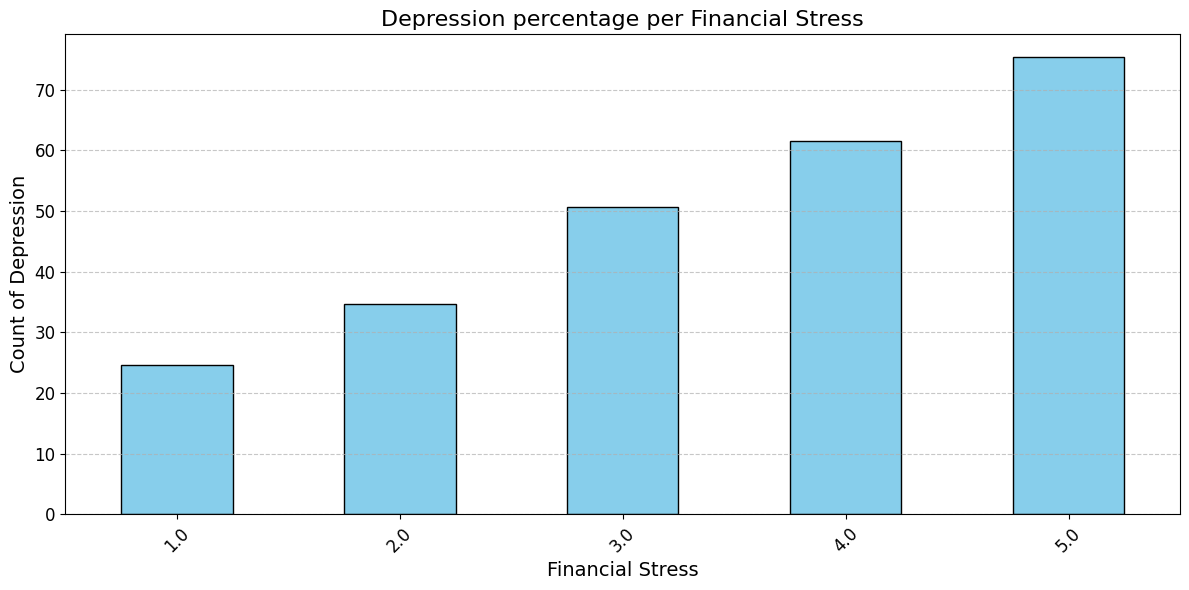

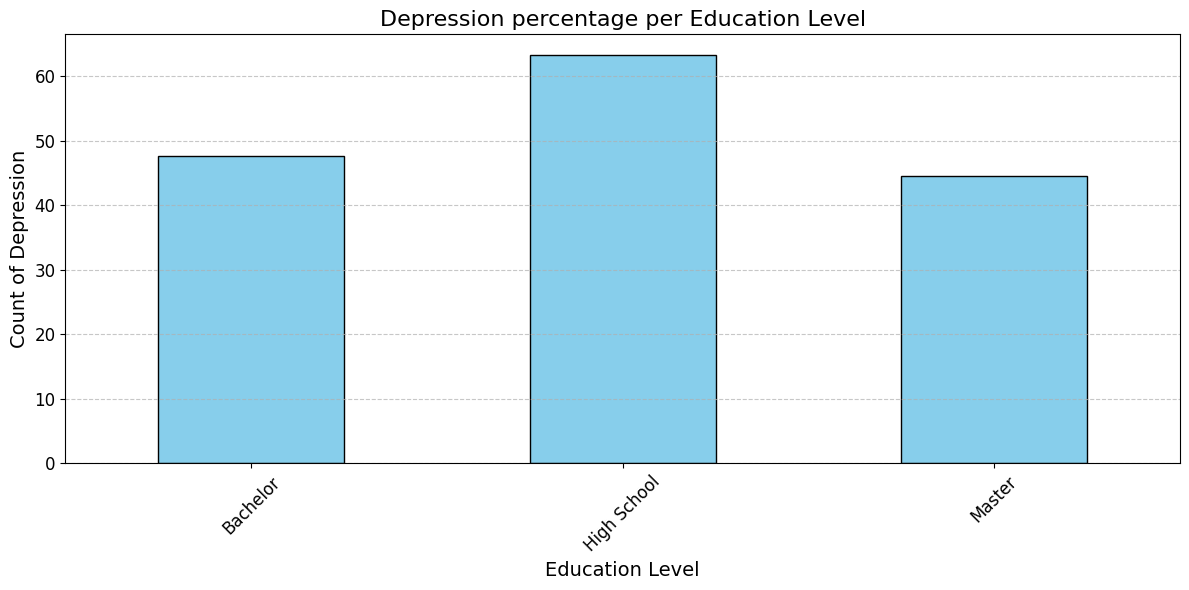

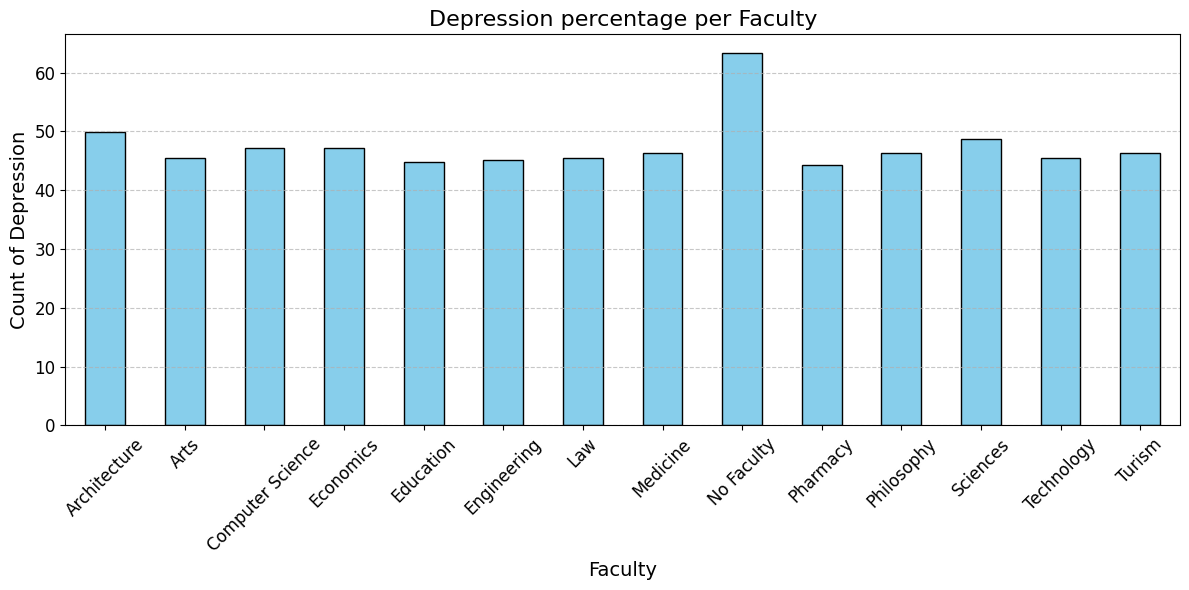

In [616]:
# List of categorical variables to visualize
selected_categorical_columns = ["City", "Academic Pressure", "Study Satisfaction", 
                                "Sleep Duration", "Dietary Habits", "Study Hours", 
                               "Financial Stress", "Education Level", "Faculty"]  

for column in selected_categorical_columns:
    percent_depression(column, data=df_resampled)
    

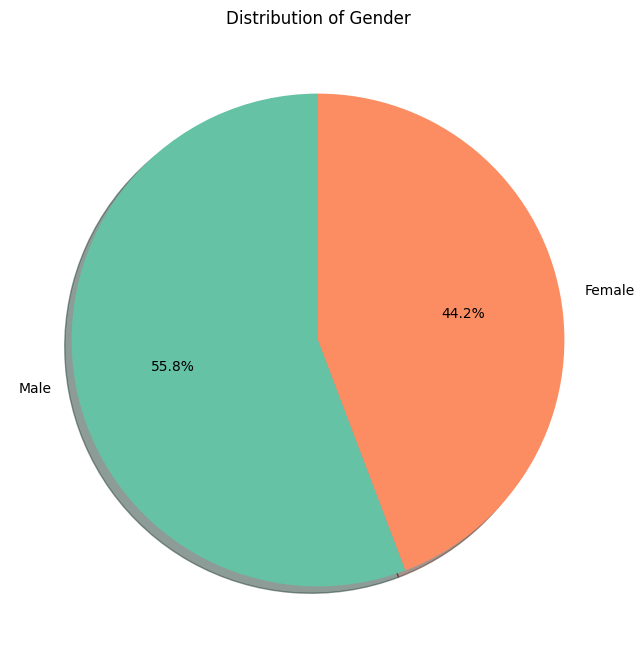

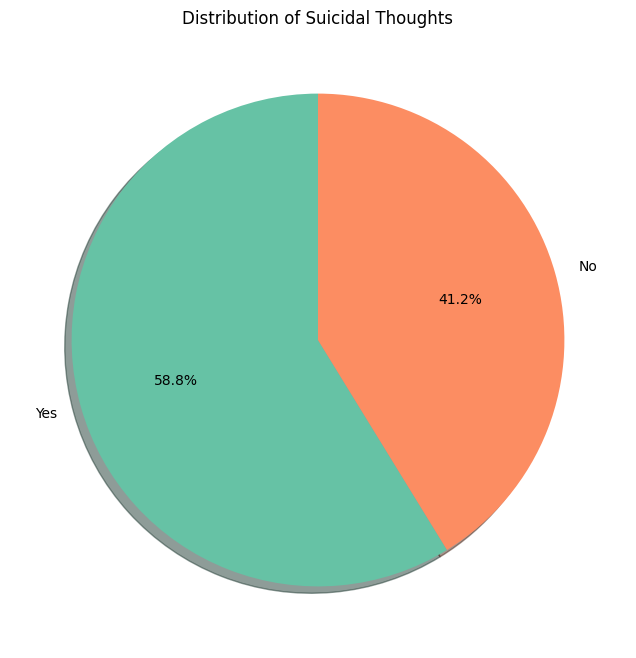

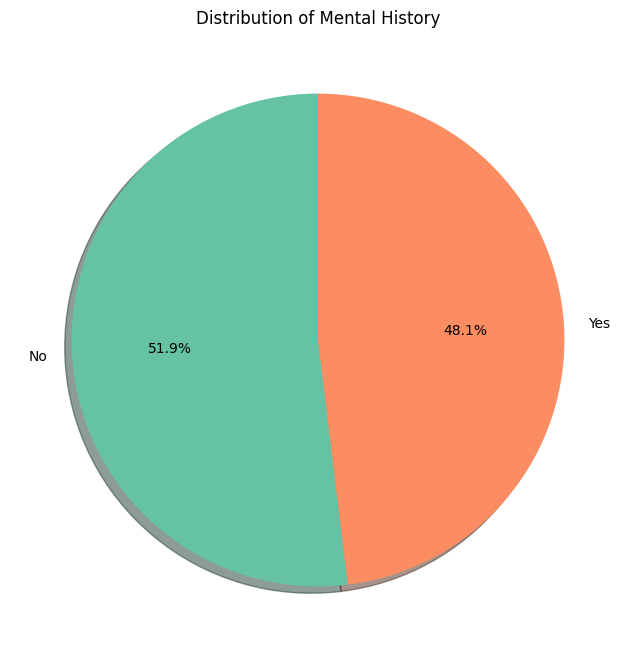

In [617]:
# Visualize through a pie chart, the binary variables distribution
# List of categorical variables for pie charts
selected_pie_columns = ["Gender", "Suicidal Thoughts", "Mental History"]  

# Generate pie charts for the selected categorical columns
for column in selected_pie_columns:
    plt.figure(figsize=(8, 8))  # Set decent size for pie charts
    
    # Calculate value counts and percentages
    value_counts = df_resampled[column].value_counts()
    percentages = value_counts / value_counts.sum() * 100
    
    # Create pie chart
    plt.pie(
        percentages, 
        labels=value_counts.index, 
        autopct='%1.1f%%',  # Show percentages with 1 decimal point
        colors=plt.cm.Set2.colors,  # Use a good color palette
        startangle=90,  # Rotate for better orientation
        shadow=True  # Add shadow for better visibility
    )
    
    # Add title
    plt.title(f"Distribution of {column}")
    
    # Show the pie chart
    plt.show()


#### Quantitative variables' analysis

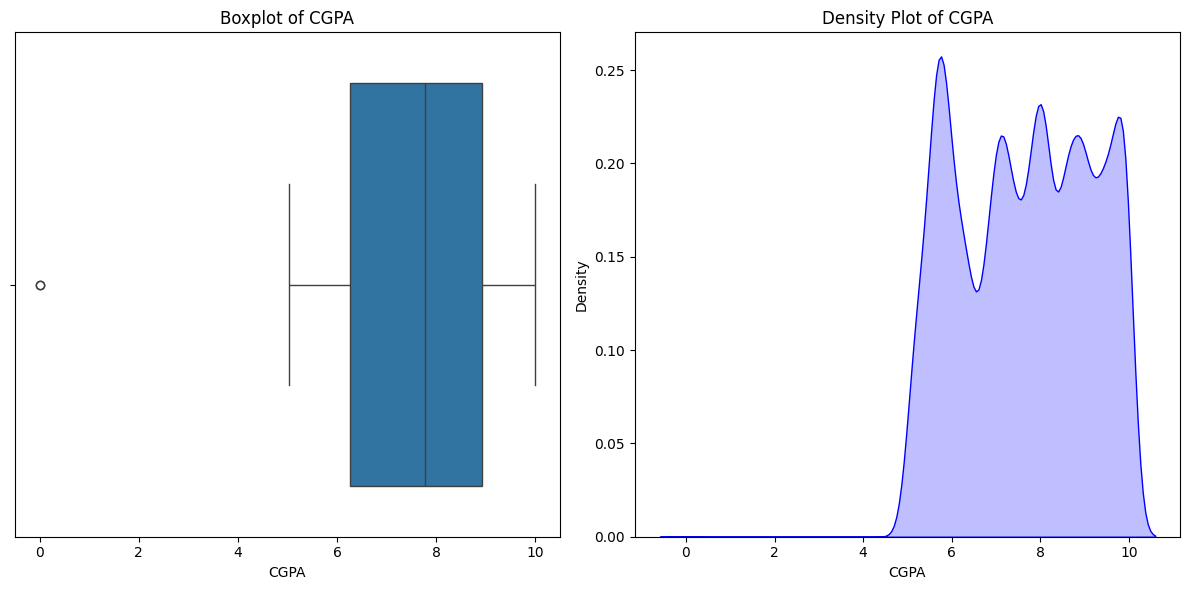

In [618]:
import seaborn as sns

# Define the variable name
var_name = 'CGPA'  # Replace with your actual variable name

# Create the figure for both plots
plt.figure(figsize=(12, 6))

# Create subplot for the boxplot
plt.subplot(1, 2, 1)  # (rows, columns, index)
sns.boxplot(data=df_resampled, x=var_name)  # Removed palette argument
plt.title(f'Boxplot of {var_name}')
plt.xlabel(var_name)

# Create subplot for the density plot
plt.subplot(1, 2, 2)
sns.kdeplot(data=df_resampled, x=var_name, fill=True, color='b')  # Replaced shade=True with fill=True
plt.title(f'Density Plot of {var_name}')
plt.xlabel(var_name)

# Display the plots
plt.tight_layout()
plt.show()

COMMENT: The CGPA variable has an outlier and it is left-skewed. 
Since the logistic regression and other classification models may be affected by skewness, it is better to check if applying a transformation to data, their distribution will be much more closer to a normal one. 

In [619]:
df_resampled['CGPA_transformed'] = np.log(df_resampled['CGPA'] + 1)  # +1 to avoid divisions per 0
df_resampled.shape
df_resampled.columns

Index(['Gender', 'Age', 'City', 'Profession', 'Academic Pressure', 'CGPA',
       'Study Satisfaction', 'Sleep Duration', 'Dietary Habits',
       'Suicidal Thoughts', 'Study Hours', 'Financial Stress',
       'Mental History', 'Education Level', 'Faculty', 'Depression',
       'CGPA_transformed'],
      dtype='object')

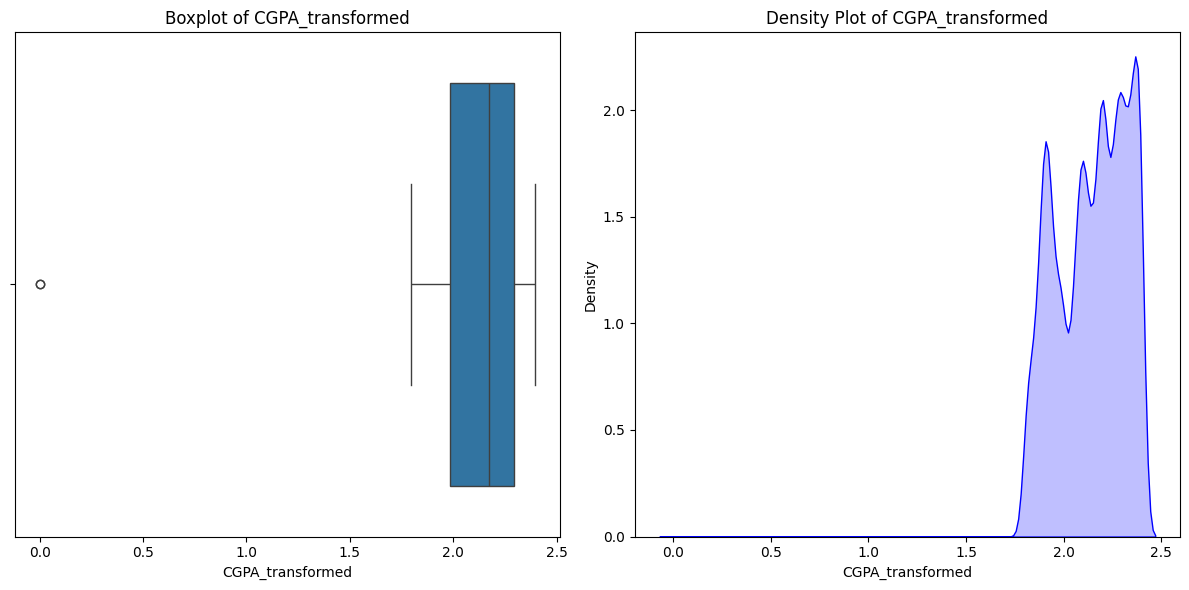

In [620]:
# Check the transformation has correctly occurred
# Define the variable name
var_name = 'CGPA_transformed'  # Replace with your actual variable name

# Create the figure for both plots
plt.figure(figsize=(12, 6))

# Create subplot for the boxplot
plt.subplot(1, 2, 1)  # (rows, columns, index)
sns.boxplot(data=df_resampled, x=var_name)  # Removed palette argument
plt.title(f'Boxplot of {var_name}')
plt.xlabel(var_name)

# Create subplot for the density plot
plt.subplot(1, 2, 2)
sns.kdeplot(data=df_resampled, x=var_name, fill=True, color='b')  # Replaced shade=True with fill=True
plt.title(f'Density Plot of {var_name}')
plt.xlabel(var_name)

# Display the plots
plt.tight_layout()
plt.show()

COMMENT: It doesn't change so much since the data are still skewed and still characterized by outliers. So, we can continue with original variable but removing the outliers.

In [621]:
df_resampled.shape
# Remove the column from the dataframe
df_resampled = df_resampled.drop('CGPA_transformed', axis=1) 
df_resampled.shape
print(df_resampled.columns)
df_resampled.shape

Index(['Gender', 'Age', 'City', 'Profession', 'Academic Pressure', 'CGPA',
       'Study Satisfaction', 'Sleep Duration', 'Dietary Habits',
       'Suicidal Thoughts', 'Study Hours', 'Financial Stress',
       'Mental History', 'Education Level', 'Faculty', 'Depression'],
      dtype='object')


(23056, 16)

In [622]:
# Remove outliers
# Calculate Q1, Q3, and IQR
Q1 = df_resampled['CGPA'].quantile(0.25)
Q3 = df_resampled['CGPA'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Check how many outliers are outside of these bounds before filtering
outliers_before = df_resampled[(df_resampled['CGPA'] < lower_bound) | (df_resampled['CGPA'] > upper_bound)]
print("Number of outliers before filtering:", len(outliers_before))

# Now, filter the outliers
df_resampled = df_resampled[(df_resampled['CGPA'] >= lower_bound) & (df_resampled['CGPA'] <= upper_bound)]

# Check the shape of the DataFrame after removing outliers
print("Shape after removing outliers:", df_resampled.shape)

# Check the min and max of 'CGPA' again
print("Min CGPA after removing outliers:", df_resampled['CGPA'].min())
print("Max CGPA after removing outliers:", df_resampled['CGPA'].max())

# Check if any outliers are still present
outliers_after = df_resampled[(df_resampled['CGPA'] < lower_bound) | (df_resampled['CGPA'] > upper_bound)]
print("Number of outliers after filtering:", len(outliers_after))

Number of outliers before filtering: 2
Shape after removing outliers: (23054, 16)
Min CGPA after removing outliers: 5.03
Max CGPA after removing outliers: 10.0
Number of outliers after filtering: 0


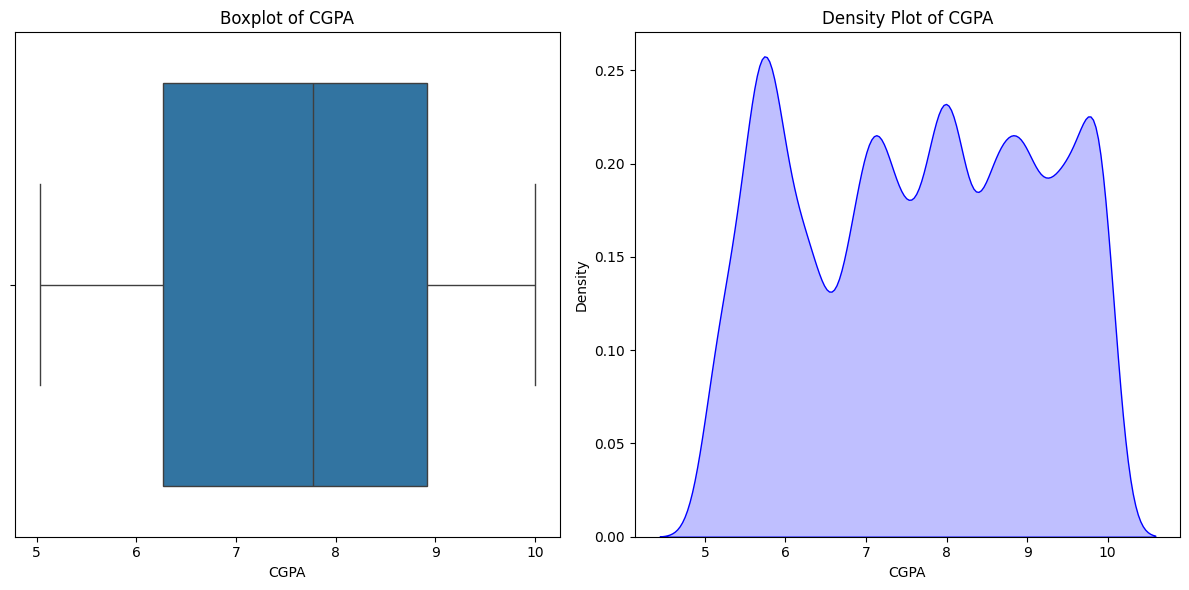

In [623]:
# Create the boxplot and density plot for the 'CGPA' column
# Variable name
var_name = 'CGPA'

# Create the figure for both plots
plt.figure(figsize=(12, 6))

# Create subplot for the boxplot
plt.subplot(1, 2, 1)  # (rows, columns, index)
sns.boxplot(data=df_resampled, x=var_name)  # Boxplot for CGPA
plt.title(f'Boxplot of {var_name}')
plt.xlabel(var_name)

# Create subplot for the density plot
plt.subplot(1, 2, 2)  # (rows, columns, index)
sns.kdeplot(data=df_resampled, x=var_name, fill=True, color='b')  # Density plot for CGPA
plt.title(f'Density Plot of {var_name}')
plt.xlabel(var_name)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

COMMENT: Since the peaks can cause overfitting, we can transform the numeric variable into a categorical one. This can help improve model performance or make the interpretation easier.

In [624]:
# Discretize the CGPA into 6 bins
bins = [5, 6, 7, 8, 9, 10]  # Define the bin edges (e.g., CGPA ranges)
labels = [5.5, 6.5, 7.5, 8.5, 9.5]  # Labels for the bins

df_resampled['CGPA_category'] = pd.cut(df_resampled['CGPA'], bins=bins, labels=labels, include_lowest=True)

print(df_resampled)

       Gender   Age       City Profession  Academic Pressure  CGPA  \
1      Female  24.0  Bangalore    Student                2.0  5.90   
2        Male  31.0   Srinagar    Student                3.0  7.03   
4      Female  25.0     Jaipur    Student                4.0  8.13   
5        Male  29.0       Pune    Student                2.0  5.70   
6        Male  30.0      Thane    Student                3.0  9.54   
...       ...   ...        ...        ...                ...   ...   
4189   Female  33.0     Kalyan    Student                4.0  9.98   
24641  Female  25.0       Agra    Student                5.0  7.22   
14175    Male  24.0     Bhopal    Student                3.0  9.11   
23644    Male  18.0     Kalyan    Student                5.0  7.94   
10248    Male  23.0    Kolkata    Student                5.0  7.15   

       Study Satisfaction     Sleep Duration Dietary Habits Suicidal Thoughts  \
1                     5.0          5-6 hours       Moderate                No 

In [625]:
df_resampled = df_resampled.drop(columns=['CGPA'])
df_resampled.shape

(23054, 16)

In [626]:
# CORRECT TYPE ASSIGNATION
# From object to category
df_resampled['Profession'] = df_resampled['Profession'].astype('category')
df_resampled['Education Level'] = df_resampled['Education Level'].astype('category')
df_resampled['Faculty'] = df_resampled['Faculty'].astype('category')
df_resampled['Dietary Habits'] = df_resampled['Dietary Habits'].astype('category')
df_resampled['Sleep Duration'] = df_resampled['Sleep Duration'].astype('category')

# From category to object
df_resampled['CGPA_category'] = df_resampled['CGPA_category'].astype('object')


print(df_resampled.dtypes)

Gender                  object
Age                    float64
City                    object
Profession            category
Academic Pressure      float64
Study Satisfaction     float64
Sleep Duration        category
Dietary Habits        category
Suicidal Thoughts       object
Study Hours            float64
Financial Stress       float64
Mental History          object
Education Level       category
Faculty               category
Depression               int64
CGPA_category           object
dtype: object


In [627]:
print(df_resampled)

       Gender   Age       City Profession  Academic Pressure  \
1      Female  24.0  Bangalore    Student                2.0   
2        Male  31.0   Srinagar    Student                3.0   
4      Female  25.0     Jaipur    Student                4.0   
5        Male  29.0       Pune    Student                2.0   
6        Male  30.0      Thane    Student                3.0   
...       ...   ...        ...        ...                ...   
4189   Female  33.0     Kalyan    Student                4.0   
24641  Female  25.0       Agra    Student                5.0   
14175    Male  24.0     Bhopal    Student                3.0   
23644    Male  18.0     Kalyan    Student                5.0   
10248    Male  23.0    Kolkata    Student                5.0   

       Study Satisfaction     Sleep Duration Dietary Habits Suicidal Thoughts  \
1                     5.0          5-6 hours       Moderate                No   
2                     5.0  Less than 5 hours        Healthy          

## PREDICTIVE STATISTICS

VARIABLE CONVERSION  
To refine the analysis, we can convert the ordinal categorical variable into discrete quantitative variable to provide order information in the execution of models. 

In [628]:
# Removing Profession from the Dataframe
df_resampled = df_resampled.drop(columns=['Profession'])
print(df_resampled)

       Gender   Age       City  Academic Pressure  Study Satisfaction  \
1      Female  24.0  Bangalore                2.0                 5.0   
2        Male  31.0   Srinagar                3.0                 5.0   
4      Female  25.0     Jaipur                4.0                 3.0   
5        Male  29.0       Pune                2.0                 3.0   
6        Male  30.0      Thane                3.0                 4.0   
...       ...   ...        ...                ...                 ...   
4189   Female  33.0     Kalyan                4.0                 2.0   
24641  Female  25.0       Agra                5.0                 3.0   
14175    Male  24.0     Bhopal                3.0                 2.0   
23644    Male  18.0     Kalyan                5.0                 5.0   
10248    Male  23.0    Kolkata                5.0                 3.0   

          Sleep Duration Dietary Habits Suicidal Thoughts  Study Hours  \
1              5-6 hours       Moderate          

COMMENT: Since I have already checked they are all students, I can remove the variable giving that information. 

In [629]:
#### Dietary Habits
# Convert the Dietary Habits from a categorical variable to a discrete quantitative one to 
# highlight the ranking between categories.
# Define a numeric mapping based on ordinal relationship

diet_numeric_mapping = {
    'Unhealthy': 1,  
    'Moderate': 2,           
    'Healthy': 3,             
    'Others': 0               
}

# Apply the numeric mapping
df_resampled['Dietary Habits'] = df_resampled['Dietary Habits'].map(diet_numeric_mapping)

#### Education Level
# Convert the Education Level from a categorical variable to a discrete quantitative one to 
# highlight the ranking between categories.
# Define a numeric mapping based on ordinal relationship

ed_level_mapping = {
    'High School': 1,
    'Bachelor': 2, 
    'Master': 3,                     
    'Others': 0             
}

#### Sleep Duration
# Convert the Sleep Duration from a categorical variable to a discrete quantitative one to 
# highlight the ranking between categories.
# Define a numeric mapping based on ordinal relationship

sleep_duration_numeric_mapping = {
    'Less than 5 hours': 4,  # Very short sleep
    '5-6 hours': 5.5,           # Short sleep
    '7-8 hours': 7.5,           # Average sleep
    'More than 8 hours': 9,   # Long sleep
    'Others': 0               # Unknown
}

# Apply the numeric mapping
df_resampled['Sleep Duration'] = df_resampled['Sleep Duration'].map(sleep_duration_numeric_mapping)

# Apply the numeric mapping
df_resampled['Education Level'] = df_resampled['Education Level'].map(ed_level_mapping)

gender_mapping = {'Male': 0, 'Female': 1}
df_resampled['Gender'] = df_resampled['Gender'].map(gender_mapping)

mental_history_mapping = {'Yes': 1, 'No': 0}
df_resampled['Mental History'] = df_resampled['Mental History'].map(mental_history_mapping)

suicidal_thoughts_mapping = {'Yes': 1, 'No': 0}
df_resampled['Suicidal Thoughts'] = df_resampled['Suicidal Thoughts'].map(suicidal_thoughts_mapping)

df_resampled['CGPA_category'] = df_resampled['CGPA_category'].astype(float)

In [630]:
df_resampled.head()

,Gender,Age,City,Academic Pressure,Study Satisfaction,Sleep Duration,Dietary Habits,Suicidal Thoughts,Study Hours,Financial Stress,Mental History,Education Level,Faculty,Depression,CGPA_category
1,1,24.0,Bangalore,2.0,5.0,5.5,2,0,3.0,2.0,1,2,Sciences,0,5.5
2,0,31.0,Srinagar,3.0,5.0,4.0,3,0,9.0,1.0,1,2,Arts,0,7.5
4,1,25.0,Jaipur,4.0,3.0,5.5,2,1,1.0,1.0,0,3,Technology,0,8.5
5,0,29.0,Pune,2.0,3.0,4.0,3,0,4.0,1.0,0,3,Philosophy,0,5.5
6,0,30.0,Thane,3.0,4.0,7.5,3,0,1.0,2.0,0,2,Sciences,0,9.5


In [631]:
df_resampled.dtypes

Gender                   int64
Age                    float64
City                    object
Academic Pressure      float64
Study Satisfaction     float64
Sleep Duration        category
Dietary Habits        category
Suicidal Thoughts        int64
Study Hours            float64
Financial Stress       float64
Mental History           int64
Education Level       category
Faculty               category
Depression               int64
CGPA_category          float64
dtype: object

In [632]:
# Analyse the relationship between the X and the Y
# T-TEST FOR ENCODED VARIABLES
from scipy import stats

# Execute the t-test for encoded variables
discrete_numerical_columns = ['Age', 'Academic Pressure', 'Study Satisfaction', 'Sleep Duration',
                     'Dietary Habits', 'Study Hours', 'Financial Stress', 'CGPA_category']  

for col in discrete_numerical_columns:
    group_0 = df_resampled[df_resampled['Depression'] == 0][col]
    group_1 = df_resampled[df_resampled['Depression'] == 1][col]
    
    t_stat, p_value = stats.ttest_ind(group_0, group_1)
    print(f"T-test for {col}: t-statistic = {t_stat:.3f}, p-value = {p_value:.3f}")

Age
T-test for Age: t-statistic = 36.200, p-value = 0.000
Academic Pressure
T-test for Academic Pressure: t-statistic = -82.361, p-value = 0.000
Study Satisfaction
T-test for Study Satisfaction: t-statistic = 26.341, p-value = 0.000
Sleep Duration
T-test for Sleep Duration: t-statistic = 12.919, p-value = 0.000
Dietary Habits
T-test for Dietary Habits: t-statistic = 32.221, p-value = 0.000
Study Hours
T-test for Study Hours: t-statistic = -32.060, p-value = 0.000
Financial Stress
T-test for Financial Stress: t-statistic = -60.382, p-value = 0.000
CGPA_category
T-test for CGPA_category: t-statistic = -2.998, p-value = 0.003


COMMENT: All the obtained p-values are less than 0.05, which means that there is a significant difference between the groups for each of the variables tested. In other words, all these variables (Age, Academic Pressure, Study Satisfaction, Sleep Duration, Dietary Habits, Study Hours, Financial Stress, CGPA_category) are significantly correlated with the target variable Depression.
=> For each variable, the zero hypothesis that there is no difference between groups (0 vs 1 for Depression) was rejected.

In [633]:
from scipy.stats import chi2_contingency

# Execute the Chi-test for categorical and binary variables
categorical_columns = ['Gender', 'City', 'Suicidal Thoughts', 
                       'Mental History', 'Education Level', 'Faculty']  

for col in categorical_columns:
    contingency_table = pd.crosstab(df_resampled['Depression'], df_resampled[col])
    
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-Square test for {col}: chi2-statistic = {chi2_stat:.3f}, p-value = {p_value:.3f}")

Gender
Chi-Square test for Gender: chi2-statistic = 0.190, p-value = 0.663
City
Chi-Square test for City: chi2-statistic = 151.807, p-value = 0.000
Suicidal Thoughts
Chi-Square test for Suicidal Thoughts: chi2-statistic = 6847.652, p-value = 0.000
Mental History
Chi-Square test for Mental History: chi2-statistic = 73.199, p-value = 0.000
Education Level
Chi-Square test for Education Level: chi2-statistic = 450.390, p-value = 0.000
Faculty
Chi-Square test for Faculty: chi2-statistic = 451.190, p-value = 0.000


COMMENT: All the obtained p-values from the Chi-Square tests, except for **Gender**, are less than 0.05, indicating a significant relationship between the groups for each of the variables tested. Specifically, **City**, **Suicidal Thoughts**, **Mental History**, **Education Level**, and **Faculty** are significantly associated with the target variable **Depression**. For each of these variables, the null hypothesis (which posits no association between the variable and Depression) was rejected, suggesting that these variables have a meaningful impact on the likelihood of depression. However, for **Gender**, the p-value is greater than 0.05, meaning that there is no significant relationship between **Gender** and **Depression**, and the null hypothesis cannot be rejected for this variable. Therefore, we can perform the classification task excluding this variable. 

# Models

In [497]:
df_resampled.head()

,Gender,Age,City,Academic Pressure,Study Satisfaction,Sleep Duration,Dietary Habits,Suicidal Thoughts,Study Hours,Financial Stress,Mental History,Education Level,Faculty,Depression,CGPA_category
1,1,24.0,Bangalore,2.0,5.0,5.5,2,0,3.0,2.0,1,2,Sciences,0,5.5
2,0,31.0,Srinagar,3.0,5.0,4.0,3,0,9.0,1.0,1,2,Arts,0,7.5
4,1,25.0,Jaipur,4.0,3.0,5.5,2,1,1.0,1.0,0,3,Technology,0,8.5
5,0,29.0,Pune,2.0,3.0,4.0,3,0,4.0,1.0,0,3,Philosophy,0,5.5
6,0,30.0,Thane,3.0,4.0,7.5,3,0,1.0,2.0,0,2,Sciences,0,9.5


In [635]:
# Convert target variable to numeric
y = df_resampled['Depression'].map({0: 0, 1: 1})  # Assuming binary

# Drop target column
X = df_resampled.drop(columns=['Depression'])

# Handle missing values
#X.fillna(X.median(), inplace=True)  # Replace missing numerical values with median
X = pd.get_dummies(X, drop_first=True)  # Convert categorical variables to numeric

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [636]:
def asses_model(estimator:ClassifierMixin): 
    """
    Function to fit, predict and asses model.
    """
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    scores = accuracy_score(y_test, y_pred)

    print(f"Accuracy: {scores}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

def model_selection(estimator:ClassifierMixin, cv:BaseCrossValidator|None = None, param_grid:dict = {}):
    """
    Function to help for model selection with cross-validation like methods and grid search
    """
    grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, 
                            cv=cv, n_jobs=-1, verbose=0, scoring='accuracy')
    
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    #print(grid_search.cv_results_)
    print("best parameters : ", grid_search.best_params_)

    return best_model

def standardize_columns(df, columns):
    """
    Standardize specified columns in a DataFrame using their mean and standard deviation.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        columns (list): A list of column names to standardize.

    Returns:
        pd.DataFrame: A copy of the DataFrame with the specified columns standardized.
        dict: A dictionary containing the mean and standard deviation for each standardized column.
    """
    scaler = StandardScaler()
    df_copy = df.copy()
    df_copy[columns] = scaler.fit_transform(df[columns])
    stats = {
        col: {"mean": scaler.mean_[i], "std": scaler.scale_[i]} 
        for i, col in enumerate(columns)
    }
    return df_copy, stats

def standardize_test_data(df, columns, stats):
    """
    Standardize specified columns in a test DataFrame using the provided mean and standard deviation.

    Args:
        df (pd.DataFrame): The test DataFrame to be standardized.
        columns (list): A list of column names to standardize.
        stats (dict): A dictionary containing the mean and standard deviation for each column 
                      (from the training dataset).

    Returns:
        pd.DataFrame: A copy of the test DataFrame with the specified columns standardized.
    """
    df_copy = df.copy()
    for col in columns:
        if col not in stats:
            raise ValueError(f"Statistics for column '{col}' not found in the provided stats.")
        if col not in df_copy.columns:
            raise ValueError(f"Column '{col}' not found in the test DataFrame.")
        
        mean = stats[col]["mean"]
        std = stats[col]["std"]
        
        df_copy[col] = (df_copy[col] - mean) / std

    return df_copy

In [637]:
def numeric_columns(df: pd.DataFrame) -> list:
    """
    Retourne le nom des colonnes numériques d'un DataFrame.
    
    Args:
    df : pd.DataFrame
        Le DataFrame dont on souhaite obtenir les colonnes numériques.
        
    Returns:
    list
        Liste des noms des colonnes numériques.
    """
    return df.select_dtypes(include=['number']).columns.tolist()

In [639]:
# Standardize numeric columns and save means and std

col_names = numeric_columns(X_train)
X_train, param_stand = standardize_columns(X_train, col_names)
X_test = standardize_test_data(X_test, col_names, param_stand)
stats = pd.DataFrame({
    'Mean': X_test.mean(),
    'Variance': X_test.var()
})
print(stats)

                              Mean  Variance
Gender                   -0.000812  1.000028
Age                      -0.017287  0.983878
Academic Pressure        -0.023626  1.005565
Study Satisfaction       -0.012040  0.963178
Suicidal Thoughts         0.012156  0.995797
Study Hours              -0.000232  1.004197
Financial Stress          0.010476  1.000879
Mental History            0.028061  1.001918
CGPA_category             0.012973  0.993885
City_Ahmedabad            0.033182  0.032087
City_Bangalore            0.027109  0.026380
City_Bhopal               0.032965  0.031885
City_Chennai              0.034049  0.032897
City_Delhi                0.025808  0.025147
City_Faridabad            0.015181  0.014954
City_Ghaziabad            0.024940  0.024324
City_Hyderabad            0.046194  0.044070
City_Indore               0.025374  0.024736
City_Jaipur               0.036651  0.035316
City_Kalyan               0.056170  0.053026
City_Kanpur               0.023205  0.022672
City_Kolka

# Logistic regression

Let's try to strat with a logistic regression in order to predict depression cases. This choice is highly motivated by the interpretability of the approach.

In [640]:


# Initialize the logistic regression model
logistic_model = LogisticRegression(max_iter=100, random_state=42, class_weight='balanced', verbose=0)
param_grid = {
    'penalty': ['l2', 'elasticnet', 'none', "l1"],
    'C': [0.1, 1, 10, 100],
    'max_iter': [100, 200, 300],
    'l1_ratio': [None, 0.1, 0.5, 0.9],  # ratio for combinaision of l1 and l2 in elasticnet
}
grid_logistic_model = model_selection(logistic_model, param_grid=param_grid)
asses_model(grid_logistic_model)


/home/ndubourg/Documents/Cours/Master2/supervised_learning/Projet/venv/lib64/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/ndubourg/Documents/Cours/Master2/supervised_learning/Projet/venv/lib64/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/ndubourg/Documents/Cours/Master2/supervised_learning/Projet/venv/lib64/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/ndubourg/Documents/Cours/Master2/supervised_learning/Projet/venv/lib64/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.wa

best parameters :  {'C': 0.1, 'l1_ratio': None, 'max_iter': 100, 'penalty': 'l2'}
Accuracy: 0.8395142051615702

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      2325
           1       0.83      0.85      0.84      2286

    accuracy                           0.84      4611
   macro avg       0.84      0.84      0.84      4611
weighted avg       0.84      0.84      0.84      4611



The classification report indicates that the logistic regression model is performing well overall, with an accuracy of 84%. For the "Not Depressed" class (0), the model has a precision of 0.85, meaning that 85% of the predictions for this class are correct. The recall is 0.83, indicating that the model successfully identifies 83% of actual "Not Depressed" cases. The F1-score for this class is 0.84, demonstrating a good balance between precision and recall.

For the "Depressed" class (1), the model performs similarly, with a precision of 0.83, meaning 83% of predictions for this class are accurate. The recall is 0.85, showing that the model identifies 85% of actual depression cases. The F1-score for this class is also 0.84, reflecting a strong balance between precision and recall.

The macro average and weighted average for precision, recall, and F1-score are all 0.84, suggesting that the model performs consistently across both classes. These results indicate that the logistic regression model is well-calibrated and is able to balance both classes effectively. Although the model is performing quite well, there could still be room for improvement through further optimization or the exploration of alternative algorithms.

# Random forest

In [649]:
random_forest_model = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50],  # Number of trees
    'max_depth': [10, 20, 30],
    'min_samples_split': [5, 10],  # Nombre minimal d'échantillons nécessaires pour diviser un nœud
    'min_samples_leaf': [2, 4],  # Nombre minimal d'échantillons nécessaires dans un nœud terminal
    'bootstrap': [True],
    'criterion': ['gini'],
    'max_samples': [None, 0.5, 0.8],  # if bootstrap = true
    'oob_score': [True],  # Out of bag error
}

grid_random_forest = model_selection(random_forest_model, param_grid=param_grid)
asses_model(grid_random_forest)

best parameters :  {'bootstrap': True, 'criterion': 'gini', 'max_depth': 20, 'max_samples': 0.8, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50, 'oob_score': True}
Accuracy: 0.8379960962914769

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      2325
           1       0.83      0.85      0.84      2286

    accuracy                           0.84      4611
   macro avg       0.84      0.84      0.84      4611
weighted avg       0.84      0.84      0.84      4611



The classification report for the Random Forest model indicates that it is performing very well, with an accuracy of approximately 83.71%. For the "Not Depressed" class (0), the model has a precision of 0.85, meaning that 85% of the predictions for this class are correct. The recall for this class is 0.83, showing that the model successfully identifies 83% of actual "Not Depressed" cases. The F1-score for this class is 0.84, reflecting a strong balance between precision and recall.

For the "Depressed" class (1), the model performs similarly well, with a precision of 0.83, meaning 83% of the predictions for this class are accurate. The recall is 0.85, indicating that the model identifies 85% of actual depression cases. The F1-score for this class is also 0.84, demonstrating a good trade-off between precision and recall.

The macro and weighted averages for precision, recall, and F1-score are all 0.84, suggesting that the model handles both classes effectively. These results are comparable to those of the logistic regression model, showing that the Random Forest model is well-calibrated and is performing consistently across both classes. The model shows a robust balance between precision and recall, making it a solid choice for this classification task. However, further optimization or experimentation with other models could potentially yield even better performance.

In [27]:
# SVC_model = SVC()

# param_grid = {
#     'C': [0.1, 1, 10, 100],
#     'kernel': ['linear'],  # Kernels , 'rbf', 'poly', 'sigmoid'
#     'degree': [2],  # for polynomial kernel
#     'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
#     'coef0': [0.0, 0.1, 0.5],  # for poly and sigmoid
#     'tol': [1e-3, 1e-4],  # tolerance to stop algo
# }

# grid_SVC = model_selection(SVC_model, param_grid=param_grid)
# asses_model(SVC_model)

In [ ]:
# knn_model = KNeighborsClassifier()

# knn_param_grid = {
#     'n_neighbors': [10, 15, 20],
#     'weights': ['uniform', 'distance'],
#     'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
#     'metric': ['euclidean', 'manhattan'],
# }

# grid_knn = model_selection(knn_model, param_grid=knn_param_grid)
# asses_model(knn_model)

# Gradient Boosting classifier

In [650]:
from sklearn.ensemble import GradientBoostingClassifier

# Définir le modèle Gradient Boosting
gb_model = GradientBoostingClassifier()

# Définir la grille de paramètres à tester
gb_param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.2],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}

grid_gb = model_selection(gb_model, param_grid=gb_param_grid)
asses_model(grid_gb)

best parameters :  {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Accuracy: 0.840164823248753

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      2325
           1       0.83      0.86      0.84      2286

    accuracy                           0.84      4611
   macro avg       0.84      0.84      0.84      4611
weighted avg       0.84      0.84      0.84      4611



The classification report for the Gradient Boosting Classifier model shows strong performance, with an accuracy of approximately 83.84%. For the "Not Depressed" class (0), the model has a precision of 0.85, meaning that 85% of the predictions for this class are correct. The recall is 0.82, indicating that the model identifies 82% of the actual "Not Depressed" cases. The F1-score for this class is 0.84, demonstrating a solid balance between precision and recall.

For the "Depressed" class (1), the model performs similarly well, with a precision of 0.82, meaning that 82% of predictions for this class are accurate. The recall is 0.86, showing that the model successfully identifies 86% of actual depression cases. The F1-score for this class is also 0.84, reflecting a good trade-off between precision and recall.

The macro and weighted averages for precision, recall, and F1-score are both 0.84, suggesting that the model handles both classes effectively and consistently. These results are comparable to those of the Random Forest and logistic regression models, indicating that the Gradient Boosting Classifier is well-calibrated and provides balanced performance for this classification task. Although the model's performance is strong, further fine-tuning or testing with other algorithms might help achieve slight improvements.

# Deep learning

We don't obtain a good enouth results let's try deep learning.

In [641]:
import torch
import torch.nn as nn
import torch.optim as optim

In [642]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_hidden_layers=3):
        super(SimpleNN, self).__init__()
        
        self.fc1 = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU()
        )
        
        self.hidden_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU()
            ) for _ in range(num_hidden_layers)
        ])
        
        self.fc_out = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        
        for layer in self.hidden_layers:
            x = layer(x)
        
        x = self.fc_out(x)
        x = self.sigmoid(x)
        
        return x


In [643]:
# Pandas dataframe to tensor
X_train_float = X_train.astype('float32')
X_test_float = X_test.astype('float32')
y_train_float = y_train.astype('float32')
y_test_float = y_test.astype('float32')

X_train_tensor = torch.tensor(X_train_float.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_float.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_float.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_float.values, dtype=torch.float32).unsqueeze(1)

print(X_train_tensor.size())
print(y_train_tensor.size())

torch.Size([18443, 59])
torch.Size([18443, 1])


In [ ]:
# Parameters
input_size = 59
hidden_size = 32
learning_rate = 0.001
epochs = 1500

# Loss function and optimizer selection
model = SimpleNN(input_size, hidden_size)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train model
for epoch in range(epochs):
    optimizer.zero_grad() # Reinitialize gradient
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor) # Compute loss

    # Compute gradient and update coefficients
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [100/2500], Loss: 0.5984
Epoch [200/2500], Loss: 0.5731
Epoch [300/2500], Loss: 0.5672
Epoch [400/2500], Loss: 0.5647
Epoch [500/2500], Loss: 0.5642
Epoch [600/2500], Loss: 0.5641
Epoch [700/2500], Loss: 0.5640
Epoch [800/2500], Loss: 0.5640
Epoch [900/2500], Loss: 0.5639
Epoch [1000/2500], Loss: 0.5639
Epoch [1100/2500], Loss: 0.5639
Epoch [1200/2500], Loss: 0.5639
Epoch [1300/2500], Loss: 0.5638
Epoch [1400/2500], Loss: 0.5638
Epoch [1500/2500], Loss: 0.5638
Epoch [1600/2500], Loss: 0.5638
Epoch [1700/2500], Loss: 0.5638
Epoch [1800/2500], Loss: 0.5638
Epoch [1900/2500], Loss: 0.5638
Epoch [2000/2500], Loss: 0.5638
Epoch [2100/2500], Loss: 0.5638
Epoch [2200/2500], Loss: 0.5638
Epoch [2300/2500], Loss: 0.5638
Epoch [2400/2500], Loss: 0.5638
Epoch [2500/2500], Loss: 0.5638


### Evaluation Metrics

**1. Recall (Sensitivity, True Positive Rate):**

$$
\text{Recall} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Negatives (FN)}}
$$

**2. Precision (Positive Predictive Value):**

$$
\text{Precision} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Positives (FP)}}
$$

**3. F1 Score (Harmonic Mean of Precision and Recall):**

$$
\text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$


In [646]:

# Make predictions
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation for evaluation
    predictions = model(X_test_tensor)  # Model output (logits)

# Apply threshold to get binary class predictions
predicted_classes = (predictions > 0.5).float()

# Convert tensors to NumPy arrays for compatibility with sklearn
y_true = y_test_tensor.numpy()
y_pred = predicted_classes.numpy()

# Generate the confusion matrix and other metrics
conf_matrix = confusion_matrix(y_true, y_pred)
precision = conf_matrix[1][1]/(conf_matrix[1][1]+conf_matrix[0][1])
recall = conf_matrix[1][1]/(conf_matrix[1][1]+conf_matrix[1][0])
F1_score = 2 * (precision * recall / (precision + recall))
accuracy = (conf_matrix[1][1] + conf_matrix[0][0]) / sum(sum(conf_matrix))

print("Confusion Matrix:")
print(conf_matrix)
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1-score: {F1_score}")
print(f"Accuracy: {accuracy}")


Confusion Matrix:
[[2013  312]
 [ 450 1836]]
Recall: 0.8031496062992126
Precision: 0.8547486033519553
F1-score: 0.8281461434370772
Accuracy: 0.8347430058555628


The results for the neural network model indicate a good performance overall, with an accuracy of approximately 83.47%. 

For the "Not Depressed" class (0), the model shows a precision of 0.85, meaning that 85% of the predictions for this class are correct. The recall for this class is 0.80, indicating that the model correctly identifies 80% of the actual "Not Depressed" cases. The F1-score for this class is 0.83, demonstrating a solid balance between precision and recall.

For the "Depressed" class (1), the precision is 0.85 as well, meaning 85% of the predictions for this class are accurate. The recall is 0.81, indicating that the model identifies 81% of actual depression cases. The F1-score for this class is 0.83, showing a good trade-off between precision and recall.

The confusion matrix indicates that there are 2013 true positives and 1836 true negatives, while 450 actual "Depressed" cases are misclassified as "Not Depressed," and 312 actual "Not Depressed" cases are misclassified as "Depressed."

Overall, the model performs well, with a good balance between precision and recall, and the F1-score reflects this balance. While the performance is strong, further optimization or the exploration of alternative architectures could help improve accuracy, particularly in reducing misclassifications between the two classes.

# Comparing models

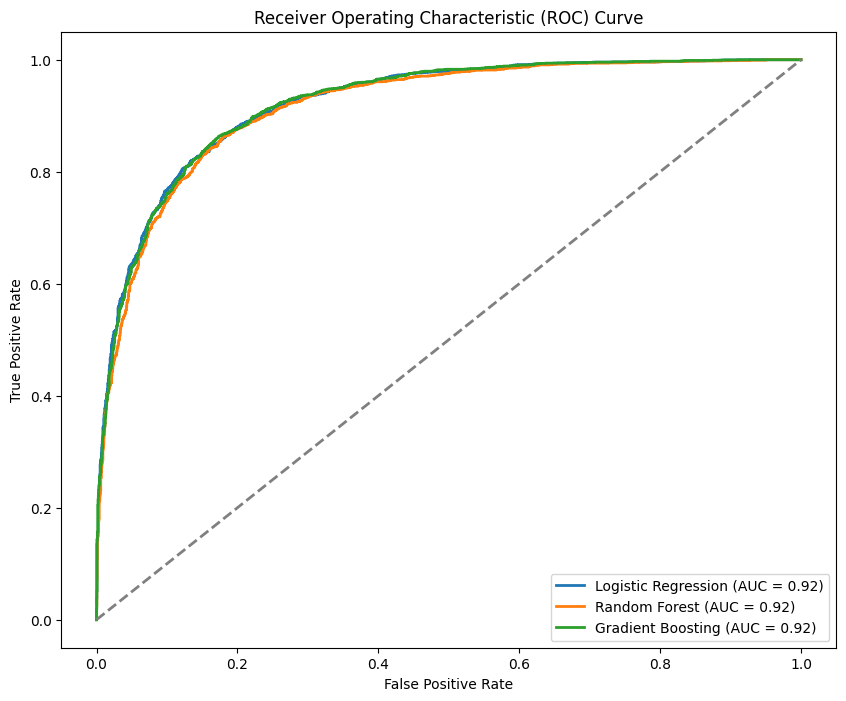

In [651]:
from sklearn.metrics import roc_curve, auc

models = {
    'Logistic Regression': grid_logistic_model,
    'Random Forest': grid_random_forest,
    'Gradient Boosting': grid_gb,
}

# Tracer les courbes ROC pour chaque modèle
plt.figure(figsize=(10, 8))

for model_name, model in models.items():
    # Ajuster le modèle
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:, 1]   
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    
    # Calculer l'AUC
    roc_auc = auc(fpr, tpr)
    
    # Tracer la courbe ROC
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Tracer la ligne diagonale (chance aléatoire)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

# Ajouter des labels et un titre
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Afficher le graphique
plt.show()

Logistic regression, random forest, and gradient boosting have an AUC of 0.92. This means that each of these models demonstrates a high level of performance in distinguishing between the positive and negative classes. An AUC of 0.92 indicates that, on average, the model has a 92% chance of correctly ranking a randomly selected positive instance higher than a randomly selected negative one. This suggests that the models are highly effective at classifying instances into the correct categories.

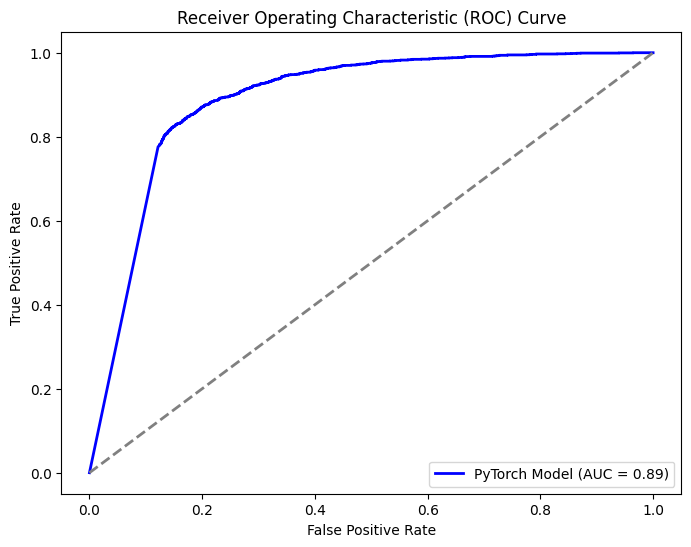

In [654]:
# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label=f'PyTorch Model (AUC = {roc_auc:.2f})')

# Plot diagonal line (random model)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

# Add labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Show the plot
plt.show()